# Создание НС для задачи регрессии

In [22]:
import pandas as pd

data = pd.read_csv('D:/PythonWork/OldZmiy/NLPWork/cars_prepared.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data = data[['odometer_value', 'year_produced', 'duration_listed', 'body_type', 'price_usd']]

data

,odometer_value,year_produced,duration_listed,body_type,price_usd
0,190000,2010,16,1,10900.00
1,290000,2002,83,1,5000.00
2,402000,2001,151,2,2800.00
3,10000,1999,86,3,9999.00
4,280000,2001,7,1,2134.11
...,...,...,...,...,...
35921,278000,1999,239,6,4220.81
35922,317000,1999,269,6,3300.00
35923,321000,2004,317,4,4800.00
35924,20000,2001,490,6,4000.00


In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = data['price_usd']
X = data.drop(['price_usd'], axis=1)

scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=scaler.get_feature_names_out())
scaled_X

,odometer_value,year_produced,duration_listed,body_type
0,-0.441632,0.874554,-0.579560,-1.304237
1,0.406258,-0.111329,0.036943,-1.304237
2,1.355894,-0.234564,0.662647,-0.780414
3,-1.967833,-0.481035,0.064548,-0.256590
4,0.321469,-0.234564,-0.662374,-1.304237
...,...,...,...,...
35921,0.304511,-0.481035,1.472382,1.314881
35922,0.635188,-0.481035,1.748428,1.314881
35923,0.669103,0.135142,2.190102,0.267234
35924,-1.883044,-0.234564,3.781967,1.314881


In [24]:
scaled_data = pd.concat([scaled_X, y], axis=1)

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader

class CarDataset(Dataset):
    def __init__(self, dataframe):
        self.features = torch.tensor(dataframe.iloc[:, :-1].values.astype(float)).float()
        self.price = torch.tensor(dataframe.iloc[:, -1].values.astype(float)).float()
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.price[idx]

In [26]:
from torch.utils.data import random_split, DataLoader

shuffled_data = scaled_data.sample(frac=1)
full_dataset = CarDataset(shuffled_data)

train_perc = 0.8
train_size = int(train_perc * len(full_dataset))
test_size = len(full_dataset) - train_size

train_ds, test_ds = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class MyRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MyRegressor, self).__init__()
        layers = []
        prev_size = input_size
        
        for h_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, h_size),
                nn.BatchNorm1d(h_size),
                nn.LeakyReLU(),
                nn.Dropout(0.8) 
            ])
            prev_size = h_size
        
        layers.append(nn.Linear(prev_size, 1)) 
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

d:\PythonWork\OldZmiy\NLPWork\.venv\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\PythonWork\OldZmiy\NLPWork\.venv\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 73263918.9956
Epoch 2, Loss: 60902319.3822
Epoch 3, Loss: 50714680.4867
Epoch 4, Loss: 47278279.3022
Epoch 5, Loss: 47042428.1600
Epoch 6, Loss: 46807019.6978
Epoch 7, Loss: 46909675.7067
Epoch 8, Loss: 46550051.8706
Epoch 9, Loss: 46553549.0533
Epoch 10, Loss: 46481089.1156


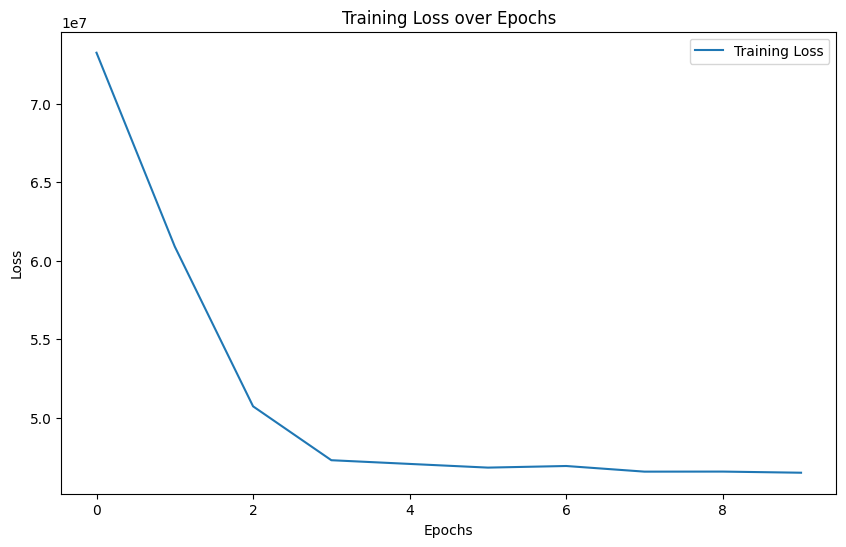

In [28]:
model = MyRegressor(input_size=4, hidden_sizes=[128, 64, 32, 16])
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

losses = [] 

torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

for epoch in range(10):
    sum_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)

        loss = criterion(outputs, targets)
  
        loss.backward()

        optimizer.step()

        sum_loss += loss.item()
    
    med_loss = sum_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {med_loss:.4f}')
    losses.append(med_loss)

plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

In [30]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  
        
        outputs = model(inputs)
        
        all_preds.append(outputs.cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        
predictions = np.concatenate(all_preds)
targets = np.concatenate(all_targets)

mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\n")

MSE: 46444344.0000
MAE: 4693.7500
RMSE: 6815.0087

